In [ ]:
from google.colab import files
up = files.upload()
FILENAME = "AirQuality.csv"

Saving AirQuality.csv to AirQuality (1).csv


In [ ]:
#1) Imports e inicio
import io, os, re, json, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# 2) CARGAR
def read_airquality_csv(path):
    try_orders = [
        dict(sep=";", decimal=",", engine="python"),
        dict(sep=",", decimal=".", engine="python"),
        dict(sep=";", decimal=".", engine="python"),
        dict(sep=",", decimal=",", engine="python"),
    ]
    last_err = None
    for opt in try_orders:
        try:
            df = pd.read_csv(path, **opt)
            return df
        except Exception as e:
            last_err = e
    raise last_err

assert os.path.exists(FILENAME), f"No se encontró el archivo {FILENAME} en el entorno."
df = read_airquality_csv(FILENAME)

df = df.dropna(axis=1, how="all")


In [ ]:
# 3) LIMPIEZA BÁSICA
for c in df.select_dtypes(include=["object"]).columns:
    df[c] = df[c].astype(str).str.strip()

for c in df.columns:
    if c.lower() not in ["date", "time"]:
        df[c] = pd.to_numeric(df[c], errors="ignore")

num_cols_tmp = df.select_dtypes(include=[np.number]).columns
df[num_cols_tmp] = df[num_cols_tmp].replace(-200, np.nan)

if "Date" in df.columns and "Time" in df.columns:
    t = df["Time"].astype(str).str.replace(".", ":", regex=False)
    df["DateTime"] = pd.to_datetime(
        df["Date"].astype(str) + " " + t,
        format="%d/%m/%Y %H:%M:%S",
        errors="coerce"
    )

print("Shape:", df.shape)
print("Columnas:", list(df.columns))

Shape: (9471, 16)
Columnas: ['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH', 'DateTime']


In [ ]:
# 4) EXPLORAR
import io

print("\n===== DESCRIPTIVE STATS =====")
try:

    desc = df.describe(datetime_is_numeric=True, include="all").transpose()
except TypeError:

    desc = df.describe(include="all").transpose()
display(desc.head(20))

print("\n===== INFO =====")
buf = io.StringIO()
df.info(buf=buf)
print(buf.getvalue())

display(df.head(20))


===== DESCRIPTIVE STATS =====


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
Date,9471,392,nan,114,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Time,9471,25,18.00.00,390,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CO(GT),7674.0,NaN,NaN,NaN,2.15275,0.1,1.1,1.8,2.9,11.9,1.453252
PT08.S1(CO),8991.0,NaN,NaN,NaN,1099.833166,647.0,937.0,1063.0,1231.0,2040.0,217.080037
NMHC(GT),914.0,NaN,NaN,NaN,218.811816,7.0,67.0,150.0,297.0,1189.0,204.459921
C6H6(GT),8991.0,NaN,NaN,NaN,10.083105,0.1,4.4,8.2,14.0,63.7,7.44982
PT08.S2(NMHC),8991.0,NaN,NaN,NaN,939.153376,383.0,734.5,909.0,1116.0,2214.0,266.831429
NOx(GT),7718.0,NaN,NaN,NaN,246.896735,2.0,98.0,180.0,326.0,1479.0,212.979168
PT08.S3(NOx),8991.0,NaN,NaN,NaN,835.493605,322.0,658.0,806.0,969.5,2683.0,256.81732
NO2(GT),7715.0,NaN,NaN,NaN,113.091251,2.0,78.0,109.0,142.0,340.0,48.370108



===== INFO =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           9471 non-null   object        
 1   Time           9471 non-null   object        
 2   CO(GT)         7674 non-null   float64       
 3   PT08.S1(CO)    8991 non-null   float64       
 4   NMHC(GT)       914 non-null    float64       
 5   C6H6(GT)       8991 non-null   float64       
 6   PT08.S2(NMHC)  8991 non-null   float64       
 7   NOx(GT)        7718 non-null   float64       
 8   PT08.S3(NOx)   8991 non-null   float64       
 9   NO2(GT)        7715 non-null   float64       
 10  PT08.S4(NO2)   8991 non-null   float64       
 11  PT08.S5(O3)    8991 non-null   float64       
 12  T              8991 non-null   float64       
 13  RH             8991 non-null   float64       
 14  AH             8991 non-null   float64       
 15  Dat

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,DateTime
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,2004-03-10 18:00:00
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,2004-03-10 19:00:00
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,2004-03-10 20:00:00
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,2004-03-10 21:00:00
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,2004-03-10 22:00:00
5,10/03/2004,23.00.00,1.2,1197.0,38.0,4.7,750.0,89.0,1337.0,96.0,1393.0,949.0,11.2,59.2,0.7848,2004-03-10 23:00:00
6,11/03/2004,00.00.00,1.2,1185.0,31.0,3.6,690.0,62.0,1462.0,77.0,1333.0,733.0,11.3,56.8,0.7603,2004-03-11 00:00:00
7,11/03/2004,01.00.00,1.0,1136.0,31.0,3.3,672.0,62.0,1453.0,76.0,1333.0,730.0,10.7,60.0,0.7702,2004-03-11 01:00:00
8,11/03/2004,02.00.00,0.9,1094.0,24.0,2.3,609.0,45.0,1579.0,60.0,1276.0,620.0,10.7,59.7,0.7648,2004-03-11 02:00:00
9,11/03/2004,03.00.00,0.6,1010.0,19.0,1.7,561.0,NaN,1705.0,NaN,1235.0,501.0,10.3,60.2,0.7517,2004-03-11 03:00:00


In [ ]:
# 5) SELECCIÓN DE OBJETIVO
priority = [
    r"pm2[._ ]?5", r"pm10", r"\bo3\b", r"ozone",
    r"no2\(gt\)", r"nox\(gt\)", r"co\(gt\)",
    r"c6h6\(gt\)", r"aqi", r"concentraci[oó]n", r"concentration",
    r"pt08\.s5\(o3\)"
]

def pick_target_auto(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if TARGET_COL is not None:
        assert TARGET_COL in df.columns, f"No existe la columna objetivo '{TARGET_COL}'."
        assert TARGET_COL in numeric_cols, f"La columna objetivo '{TARGET_COL}' no es numérica."
        return TARGET_COL

    for pat in priority:
        for c in df.columns:
            if re.search(pat, str(c), re.I) and c in numeric_cols:
                return c

    for c in reversed(numeric_cols):
        if not re.search(r"\bid\b|\bidx\b|\bindex\b", c, re.I):
            return c
    return None

target = pick_target_auto(df)
assert target is not None, "No se pudo identificar una columna objetivo numérica."
print("\nObjetivo seleccionado (y):", target)



Objetivo seleccionado (y): PT08.S5(O3)


In [ ]:
# 6) FEATURES
if "DateTime" in df.columns:
    dt = df["DateTime"]
    df["year"]  = dt.dt.year
    df["month"] = dt.dt.month
    df["day"]   = dt.dt.day
    df["dow"]   = dt.dt.dayofweek
    df["hour"]  = dt.dt.hour

feature_cols = [c for c in df.columns if c != target]
for c_drop in ["Date", "Time", "DateTime"]:
    if c_drop in feature_cols:
        feature_cols.remove(c_drop)

numeric_cols = [c for c in feature_cols if pd.api.types.is_numeric_dtype(df[c])]
categorical_cols = [c for c in feature_cols if not pd.api.types.is_numeric_dtype(df[c])]

print("\n#Features totales:", len(feature_cols))
print("#Numéricas:", len(numeric_cols), " / #Categorías:", len(categorical_cols))


#Features totales: 17
#Numéricas: 17  / #Categorías: 0


In [ ]:
# ---- 7) PREPROCESAMIENTO ----
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer


try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:

    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ],
    remainder="drop"
)


In [ ]:
# 8) MODELAR (Regresión Lineal)
model = LinearRegression()
pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", model)
])

X = df[feature_cols].copy()
y = df[target].copy()

mask = ~pd.isna(y)
X, y = X.loc[mask], y.loc[mask]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2 if X.shape[0] >= 10 else 0.2, random_state=42
)

pipe.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CO(GT)', 'PT08.S1(CO)',
                                                   'NMHC(GT)', 'C6H6(GT)',
                                                   'PT08.S2(NMHC)', 'NOx(GT)',
                                                   'PT08.S3(NOx)', 'NO2(GT)',
                                                   'PT08.S4(NO2)', 'T', 'RH',
                                                   'AH', 'year', 'month', 'day',
                                                   'dow', 'hour']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  [])])),
                ('model', LinearRegression())])

In [ ]:
# 9) PREDECIR & EVALUAR
y_pred_train = pipe.predict(X_train)
y_pred_test  = pipe.predict(X_test)

def metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

train_metrics = metrics(y_train, y_pred_train)
test_metrics  = metrics(y_test, y_pred_test)

print("\n=== MÉTRICAS TRAIN ===")
for k,v in train_metrics.items():
    print(f"{k}: {v:.4f}")

print("\n=== MÉTRICAS TEST ===")
for k,v in test_metrics.items():
    print(f"{k}: {v:.4f}")
# MÉTRICAS EN PORCENTAJE (nivel de precisión)
import numpy as np

def mape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mask = y_true != 0  # evita división por cero
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.abs(y_true) + np.abs(y_pred)
    mask = denom != 0
    return np.mean(2.0 * np.abs(y_pred[mask] - y_true[mask]) / denom[mask]) * 100

# Cálculos en TEST
mape_test  = mape(y_test, y_pred_test)
smape_test = smape(y_test, y_pred_test)
r2_pct     = r2_score(y_test, y_pred_test) * 100

precision_smape = 100 - smape_test
precision_mape  = None if np.isnan(mape_test) else 100 - mape_test

mask10 = np.asarray(y_test, dtype=float) != 0
within_10 = np.mean(
    (np.abs((np.asarray(y_pred_test)[mask10] - np.asarray(y_test)[mask10])
            / np.asarray(y_test)[mask10])) <= 0.10
) * 100

print("\n=== MÉTRICAS EN PORCENTAJE (TEST) ===")
print(f"Precisión (100 - sMAPE): {precision_smape:.2f}%   [sMAPE={smape_test:.2f}%]")
if precision_mape is not None:
    print(f"Precisión (100 - MAPE):  {precision_mape:.2f}%   [MAPE={mape_test:.2f}%]")
print(f"Varianza explicada (R²): {r2_pct:.2f}%")
print(f"Predicciones dentro de ±10% del valor real: {within_10:.2f}%")



=== MÉTRICAS TRAIN ===
MAE: 100.4036
MSE: 16632.0811
RMSE: 128.9654
R2: 0.8949

=== MÉTRICAS TEST ===
MAE: 100.3250
MSE: 17591.7594
RMSE: 132.6339
R2: 0.8902

=== MÉTRICAS EN PORCENTAJE (TEST) ===
Precisión (100 - sMAPE): 89.34%   [sMAPE=10.66%]
Precisión (100 - MAPE):  89.16%   [MAPE=10.84%]
Varianza explicada (R²): 89.02%
Predicciones dentro de ±10% del valor real: 57.03%


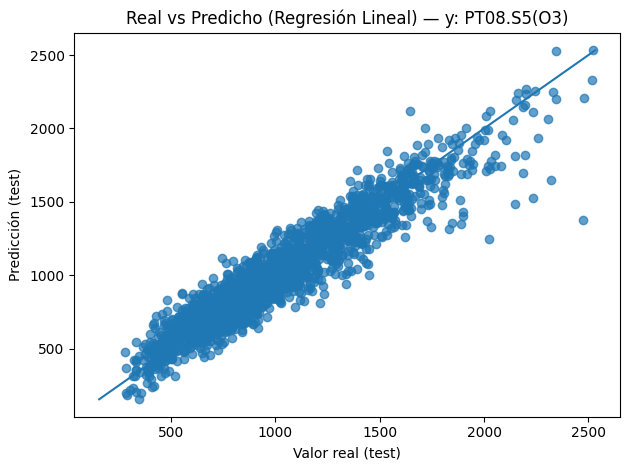

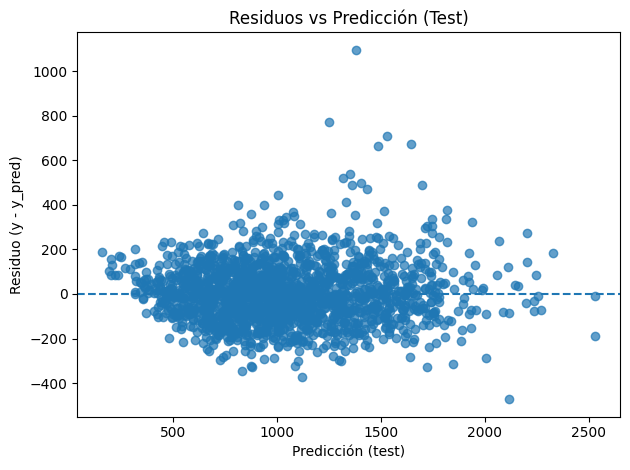

,feature,coef,abs_coef
4,PT08.S2(NMHC),225.857347,225.857347
1,PT08.S1(CO),167.342151,167.342151
9,T,-90.989385,90.989385
3,C6H6(GT),-70.839420,70.839420
6,PT08.S3(NOx),-45.438122,45.438122
16,hour,-40.563243,40.563243
7,NO2(GT),35.104499,35.104499
5,NOx(GT),34.402621,34.402621
11,AH,32.253327,32.253327
10,RH,-28.649343,28.649343


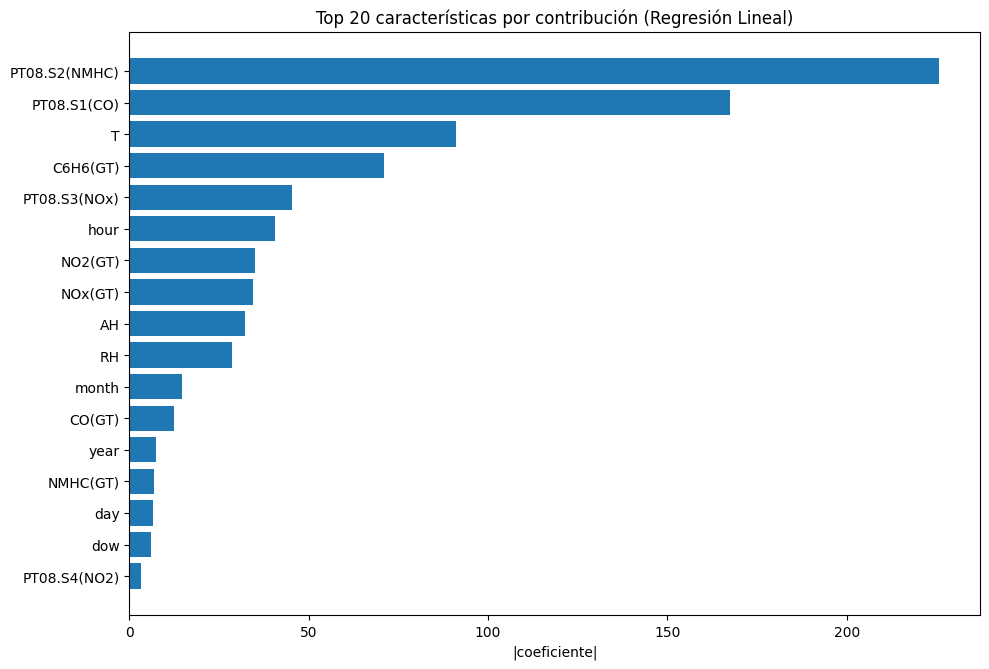


Archivos exportados:
 - airquality_linear_predictions.csv
 - airquality_linear_report.json


In [ ]:
# ---- 10) GRAFICAR ----
plt.figure()
plt.scatter(y_test, y_pred_test, alpha=0.7)
plt.xlabel("Valor real (test)")
plt.ylabel("Predicción (test)")
plt.title(f"Real vs Predicho (Regresión Lineal) — y: {target}")
lims = [min(y_test.min(), y_pred_test.min()), max(y_test.max(), y_pred_test.max())]
plt.plot(lims, lims)
plt.tight_layout()
plt.show()

resid = y_test - y_pred_test
plt.figure()
plt.scatter(y_pred_test, resid, alpha=0.7)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicción (test)")
plt.ylabel("Residuo (y - y_pred)")
plt.title("Residuos vs Predicción (Test)")
plt.tight_layout()
plt.show()

def get_feature_names(preprocessor, numeric_cols, categorical_cols):
    names = []
    names.extend(numeric_cols)
    if len(categorical_cols) > 0:
        ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
        names.extend(ohe.get_feature_names_out(categorical_cols).tolist())
    return names

try:
    feature_names = get_feature_names(preprocessor, numeric_cols, categorical_cols)
    coefs = pipe.named_steps["model"].coef_
    if hasattr(coefs, "shape") and len(feature_names) == coefs.shape[0]:
        imp = pd.DataFrame({"feature": feature_names,
                            "coef": coefs,
                            "abs_coef": np.abs(coefs)}).sort_values("abs_coef", ascending=False).head(20)
        display(imp)

        plt.figure(figsize=(10, max(4, 0.4*len(imp))))
        plt.barh(imp["feature"][::-1], imp["abs_coef"][::-1])
        plt.xlabel("|coeficiente|")
        plt.title("Top 20 características por contribución (Regresión Lineal)")
        plt.tight_layout()
        plt.show()
except Exception as e:
    print("No fue posible graficar importancia de coeficientes:", e)

# 11) EXPORTAR
pred_df = pd.DataFrame({"y_real": y_test.values, "y_pred": y_pred_test}, index=y_test.index)
pred_path = "airquality_linear_predictions.csv"
pred_df.to_csv(pred_path, index=True)

report = {
    "archivo": FILENAME,
    "objetivo": target,
    "n_filas": int(df.shape[0]),
    "n_cols": int(df.shape[1]),
    "features_totales": len(feature_cols),
    "features_numericas": len(numeric_cols),
    "features_categoricas": len(categorical_cols),
    "metricas_train": train_metrics,
    "metricas_test": test_metrics
}
report_path = "airquality_linear_report.json"
with open(report_path, "w", encoding="utf-8") as f:
    json.dump(report, f, ensure_ascii=False, indent=2)

print("\nArchivos exportados:")
print(" -", pred_path)
print(" -", report_path)
